#### Importing Libraries

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from scipy import stats

#### Functions for pose detection 

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections

def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                         mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                         mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                         ) 
    
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    
    return pose

#### Read data from folder

In [4]:
DATA_PATH = os.path.join('Yoga_Pose_Final') 
actions = np.array(['Cobra','DownDog','StandingForwardBend','Tree','Warrior1'])
label_map = {label:num for num, label in enumerate(actions)}
sequence_length = 5

sequences, labels = [], []
for action in actions:
    for i in range(30):
        for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action, str(i) ))).astype(int):
            window = []
    #         print(sequence)
            for frame_num in range(sequence_length):
    #             print(frame_num)
                res = np.load(os.path.join(DATA_PATH, action, str(i), str(sequence), "{}.npy".format(frame_num)))
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])

#### Spliting Train and Validation Set

In [5]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print(X.shape, y.shape, X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(1500, 5, 132) (1500, 5) (1200, 5, 132) (300, 5, 132) (1200, 5) (300, 5)


#### LSTM Model with tensor flow keras

In [7]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [8]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(5,132)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             50432     
                                                                 
 lstm_1 (LSTM)               (None, 5, 128)            98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 205,061
Trainable params: 205,061
Non-trai

In [10]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [11]:
information = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs= 100, callbacks=[tb_callback])

Epoch 1/100
38/38 [==============================] - 9s 57ms/step - loss: 1.3812 - categorical_accuracy: 0.3692 - val_loss: 1.3525 - val_categorical_accuracy: 0.4500
Epoch 2/100
38/38 [==============================] - 1s 24ms/step - loss: 1.0517 - categorical_accuracy: 0.5008 - val_loss: 1.0413 - val_categorical_accuracy: 0.4767
Epoch 3/100
38/38 [==============================] - 1s 24ms/step - loss: 0.8023 - categorical_accuracy: 0.6383 - val_loss: 0.9777 - val_categorical_accuracy: 0.5867
Epoch 4/100
38/38 [==============================] - 1s 25ms/step - loss: 0.5900 - categorical_accuracy: 0.7650 - val_loss: 0.5920 - val_categorical_accuracy: 0.8033
Epoch 5/100
38/38 [==============================] - 1s 27ms/step - loss: 0.4162 - categorical_accuracy: 0.8417 - val_loss: 0.2719 - val_categorical_accuracy: 0.9000
Epoch 6/100
38/38 [==============================] - 1s 26ms/step - loss: 0.2749 - categorical_accuracy: 0.8942 - val_loss: 0.2490 - val_categorical_accuracy: 0.9167
Epoc

38/38 [==============================] - 1s 26ms/step - loss: 0.0976 - categorical_accuracy: 0.9442 - val_loss: 0.0806 - val_categorical_accuracy: 0.9467
Epoch 100/100
38/38 [==============================] - 1s 25ms/step - loss: 0.1629 - categorical_accuracy: 0.9292 - val_loss: 0.1960 - val_categorical_accuracy: 0.9367


#### Accuracy and loss plots

Text(0, 0.5, 'Accuracy')

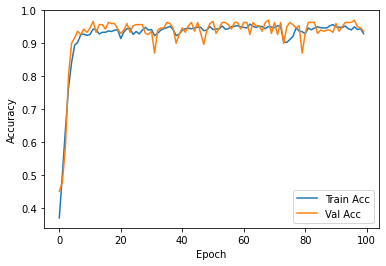

In [12]:
plt.plot(information.history['categorical_accuracy'], label = 'Train Acc')
plt.plot(information.history['val_categorical_accuracy'], label = 'Val Acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

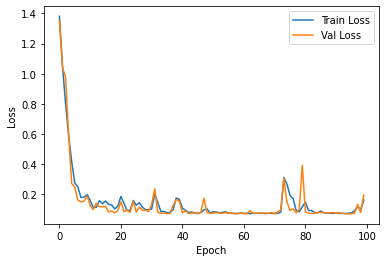

In [13]:
plt.plot(information.history['loss'], label = 'Train Loss')
plt.plot(information.history['val_loss'], label = 'Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

#### Prediction

In [15]:
yhat = model.predict(X_val)
print(yhat.shape, yhat)

(300, 5) [[1.3248414e-06 6.7225366e-05 9.9991608e-01 1.7750627e-07 1.5312287e-05]
 [1.0940472e-26 1.1822601e-28 2.2286289e-25 1.0000000e+00 4.2639439e-24]
 [2.0585303e-23 2.3105928e-25 3.6476772e-22 1.0000000e+00 7.4012486e-21]
 ...
 [8.6229700e-01 5.5287615e-04 1.2971365e-04 5.0077429e-06 1.3701537e-01]
 [1.2868672e-11 1.1404813e-08 2.8647781e-10 1.0825955e-14 1.0000000e+00]
 [5.7137266e-05 2.0058646e-03 9.9590552e-01 3.6451918e-06 2.0278606e-03]]


In [16]:
ytrue = np.argmax(y_val, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [17]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[234,   0],
        [  4,  62]],

       [[216,  13],
        [  0,  71]],

       [[240,   1],
        [  4,  55]],

       [[249,   2],
        [  0,  49]],

       [[242,   3],
        [ 11,  44]]], dtype=int64)

In [18]:
accuracy_score(ytrue, yhat)

0.9366666666666666

#### Live action classification of yoga poses

In [19]:
colors = [(245,117,16), (117,245,16), (16,117,245), (312,232,215), (113,247,125)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [22]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)   #to test live action

# to test with recorded video as test dataset
# video = 'DD1.mp4'
# cap = cv2.VideoCapture(video)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-5:]
        
        if len(sequence) == 5:
            
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-5:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[2.1153215e-37 0.0000000e+00 8.5593653e-30 1.0000000e+00 1.5606751e-29]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 2.9422027e-38]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[0. 0. 0. 1. 0.]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[0. 0. 0. 1. 0.]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[0. 0. 0. 1. 0.]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[0. 0. 0. 1. 0.]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[0.0000000e+00 0.0000000e+00 2.8800793e-33 1.0000000e+00 9.4291930e-34]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[1.6915084e-09 2.2111463e-10 6.3053194e-09 1.0000000e+00 4.1424336e-08]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[4.9661556e-11 5.3613307e-12 2.0797565e-10 1.0000000e+00 1.6854602e-09]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[4.6922466e-12 4.2051537e-13 2.1642872e-11 1.0000000e+00 1.9944710e-10]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[8.9432921e-13 6.8305442e-14 4.3716441e-12 1.0000000e+00 4.4610763e-11]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[1.6440605e-12 1.2503173e-13 7.9563352e-12 1.0000000e+00 8.1641492e-11]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[2.6321115e-12 2.0141251e-13 1.2751053e-11 1.0000000e+00 1.3158732e-10]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[4.1766269e-12 3.1672131e-13 2.0405372e-11 1.0000000e+00 2.0847647e-10]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[5.88

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[1.4496529e-12 9.8830917e-14 7.5483101e-12 1.0000000e+00 7.7949827e-11]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[1.3432387e-12 9.1479348e-14 7.0432510e-12 1.0000000e+00 7.2914612e-11]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[9.5565428e-13 6.4504236e-14 5.0836410e-12 1.0000000e+00 5.3598407e-11]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[5.3850734e-13 3.5520171e-14 2.9192057e-12 1.0000000e+00 3.1925081e-11]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[1.9753718e-13 1.2457557e-14 1.1053648e-12 1.0000000e+00 1.2863273e-11]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[6.6831665e-14 3.9867660e-15 3.8930873e-13 1.0000000e+00 4.9612961e-12]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[1.0830168e-14 5.8530755e-16 6.7912473e-14 1.0000000e+00 9.0752612e-13]
Tree
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[7.54

[1.3862869e-04 1.2455670e-03 9.9807668e-01 4.4535718e-05 4.9454125e-04]
StandingForwardBend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[2.2405999e-05 3.2330045e-04 9.9954295e-01 5.9164586e-06 1.0539581e-04]
StandingForwardBend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[5.9208651e-06 1.2014981e-04 9.9983823e-01 1.3627448e-06 3.4358916e-05]
StandingForwardBend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[1.3008438e-06 3.8163053e-05 9.9995077e-01 2.5748761e-07 9.5439655e-06]
StandingForwardBend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[9.9143926e-07 2.9588116e-05 9.9996185e-01 1.9364685e-07 7.3564720e-06]
StandingForwardBend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[6.8031210e-07 2.1718610e-05 9.9997222e-01 1.2819639e-07 5.2241312e-06]
StandingForwardBend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[4.2583571e-07 1.4934775e-05 9.9998105e-01 7.6334885e-08 3.4331183e-06]
StandingForwardBend
<class 'mediap

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[1.6632266e-09 4.7420631e-08 1.7876164e-07 6.2993888e-10 9.9999976e-01]
Warrior1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[5.8949390e-10 2.9468188e-08 6.8359476e-08 6.4676181e-11 9.9999988e-01]
Warrior1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[1.7078562e-10 1.6650974e-08 1.6774115e-08 3.5942545e-12 1.0000000e+00]
Warrior1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[1.14689785e-10 1.39167886e-08 1.05302602e-08 1.40245465e-12
 1.00000000e+00]
Warrior1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[1.2121398e-10 1.5781884e-08 9.4647561e-09 1.1951068e-12 1.0000000e+00]
Warrior1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[3.5185926e-10 2.9475162e-08 2.6227005e-08 9.0804595e-12 1.0000000e+00]
Warrior1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
[2.2700555e-09 7.3327818e-08 1.7189224e-07 4.2314444e-10 9.9999976e-01]
Warrior1
<class 'mediapipe.python.sol